**PROJECT TITLE:**

**Climate-Induced Disaster Pattern Analysis: Detecting Emerging Risks from Historical Events**

PROBLEM STATEMENT :

In recent decades, the frequency and intensity of natural disasters such as floods, storms, droughts, wildfires, and cyclones have increased significantly. Scientific studies suggest that these changes are closely linked to climate change and its cascading effects on weather systems. However, disaster management efforts are often reactive rather than proactive due to a lack of clear insights into long-term patterns and emerging risks.

This project aims to analyze historical global disaster data to identify climate-induced trends, patterns, and emerging risks. By studying decades of disaster records, the project will highlight how climate change is reshaping disaster frequency, geographic spread, and human impact. These insights can support early warning systems, policy formulation, and disaster preparedness strategies, ultimately reducing vulnerabilities and saving lives.

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
import joblib
import warnings
warnings.filterwarnings('ignore')

# Prophet & statsmodels
from prophet import Prophet
import statsmodels.api as sm

sns.set(style="whitegrid")


In [5]:
# Choose one dataset explicitly
DATA_PATH = "/content/1900_2021_DISASTERS.xlsx - emdat data.csv"

# or, if you want the 1970–2021 file:
# DATA_PATH = "/content/1970-2021_DISASTERS.xlsx - emdat data.csv"

print("Using dataset:", DATA_PATH)

# Load dataset
if DATA_PATH.lower().endswith(('.xls', '.xlsx')):
    df = pd.read_excel(DATA_PATH, engine="openpyxl")
else:
    df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head(3)


Using dataset: /content/1900_2021_DISASTERS.xlsx - emdat data.csv
Shape: (16126, 45)
Columns: ['Year', 'Seq', 'Glide', 'Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'Disaster Subsubtype', 'Event Name', 'Country', 'ISO', 'Region', 'Continent', 'Location', 'Origin', 'Associated Dis', 'Associated Dis2', 'OFDA Response', 'Appeal', 'Declaration', 'Aid Contribution', 'Dis Mag Value', 'Dis Mag Scale', 'Latitude', 'Longitude', 'Local Time', 'River Basin', 'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day', 'Total Deaths', 'No Injured', 'No Affected', 'No Homeless', 'Total Affected', "Insured Damages ('000 US$)", "Total Damages ('000 US$)", 'CPI', 'Adm Level', 'Admin1 Code', 'Admin2 Code', 'Geo Locations']


,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,...,No Affected,No Homeless,Total Affected,Insured Damages ('000 US$),Total Damages ('000 US$),CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,1900,9002,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,Cabo Verde,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
1,1900,9001,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,India,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
2,1902,12,NaN,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Guatemala,...,NaN,NaN,NaN,NaN,25000.0,3.350513,NaN,NaN,NaN,NaN


In [6]:
if DATA_PATH is None:
    df = pd.DataFrame()
else:
    # If "csv" is in filename, load as CSV, else Excel
    if "csv" in DATA_PATH.lower():
        df = pd.read_csv(DATA_PATH)
    else:
        df = pd.read_excel(DATA_PATH, engine='openpyxl')

print("Shape:", df.shape)
print("Columns:")
print(df.columns.tolist())
df.head(3)


Shape: (16126, 45)
Columns:
['Year', 'Seq', 'Glide', 'Disaster Group', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'Disaster Subsubtype', 'Event Name', 'Country', 'ISO', 'Region', 'Continent', 'Location', 'Origin', 'Associated Dis', 'Associated Dis2', 'OFDA Response', 'Appeal', 'Declaration', 'Aid Contribution', 'Dis Mag Value', 'Dis Mag Scale', 'Latitude', 'Longitude', 'Local Time', 'River Basin', 'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day', 'Total Deaths', 'No Injured', 'No Affected', 'No Homeless', 'Total Affected', "Insured Damages ('000 US$)", "Total Damages ('000 US$)", 'CPI', 'Adm Level', 'Admin1 Code', 'Admin2 Code', 'Geo Locations']


,Year,Seq,Glide,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,Disaster Subsubtype,Event Name,Country,...,No Affected,No Homeless,Total Affected,Insured Damages ('000 US$),Total Damages ('000 US$),CPI,Adm Level,Admin1 Code,Admin2 Code,Geo Locations
0,1900,9002,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,Cabo Verde,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
1,1900,9001,NaN,Natural,Climatological,Drought,Drought,NaN,NaN,India,...,NaN,NaN,NaN,NaN,NaN,3.221647,NaN,NaN,NaN,NaN
2,1902,12,NaN,Natural,Geophysical,Earthquake,Ground movement,NaN,NaN,Guatemala,...,NaN,NaN,NaN,NaN,25000.0,3.350513,NaN,NaN,NaN,NaN


Auto-detect columns + manual override

In [8]:
# Auto-detect likely columns
cols_low = {c.lower(): c for c in df.columns}

def find_col(key_words):
    for kw in key_words:
        for low, orig in cols_low.items():
            if kw in low:
                return orig
    return None

col_map = {
    'year': find_col(['year','yr','date']),
    'disaster_type': find_col(['disaster','event','type']),
    'country': find_col(['country','countries','location']),
    'deaths': find_col(['death','deaths','total_deaths']),
    'affected': find_col(['affected','people','persons','involved']),
    'damage': find_col(['damage','economic','cost','estimated'])
}
print("Auto-detected:", col_map)

# 👇 If detection is wrong, fix here manually:
# Example: manual_map = {'Year':'year', 'Disaster Type':'disaster_type', 'Country':'country'}
manual_map = {}

# Apply manual overrides
for k,v in manual_map.items():
    col_map[k] = v

# Rename columns
rename_map = {v:k for k,v in col_map.items() if v is not None}
df = df.rename(columns=rename_map)
print("Columns after rename:", df.columns.tolist())


Auto-detected: {'year': 'year', 'disaster_type': 'disaster_type', 'country': 'country', 'deaths': 'deaths', 'affected': 'affected', 'damage': 'damage'}
Columns after rename: ['year', 'Seq', 'Glide', 'disaster_type', 'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype', 'Disaster Subsubtype', 'Event Name', 'country', 'ISO', 'Region', 'Continent', 'Location', 'Origin', 'Associated Dis', 'Associated Dis2', 'OFDA Response', 'Appeal', 'Declaration', 'Aid Contribution', 'Dis Mag Value', 'Dis Mag Scale', 'Latitude', 'Longitude', 'Local Time', 'River Basin', 'Start Year', 'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day', 'deaths', 'No Injured', 'affected', 'No Homeless', 'Total Affected', 'damage', "Total Damages ('000 US$)", 'CPI', 'Adm Level', 'Admin1 Code', 'Admin2 Code', 'Geo Locations']


Clean numeric fields & text

In [9]:
def clean_numeric_column(df, col):
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',','').str.replace(' ','')
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

for col in ['deaths','affected','damage']:
    df = clean_numeric_column(df, col)

# Standardize disaster types
if 'disaster_type' in df.columns:
    df['disaster_type'] = df['disaster_type'].astype(str).str.strip().str.title()
    norm = {
        'Floods':'Flood','Flooding':'Flood',
        'Heat Wave':'Heatwave','Heat Waves':'Heatwave',
        'Earthquakes':'Earthquake','Earthquake':'Earthquake',
        'Wildfires':'Wildfire','Wildfire':'Wildfire'
    }
    df['disaster_type'] = df['disaster_type'].map(norm).fillna(df['disaster_type'])

# Convert year
if 'year' in df.columns:
    df['year'] = pd.to_datetime(df['year'], errors='coerce').dt.year.fillna(df['year'])
    df['year'] = pd.to_numeric(df['year'], errors='coerce').astype('Int64')

# Drop duplicates
df = df.drop_duplicates().reset_index(drop=True)

print("After cleaning shape:", df.shape)
print(df[['year','country','disaster_type','deaths','affected','damage']].head())


After cleaning shape: (16126, 45)
   year     country disaster_type     deaths  affected  damage
0  1970  Cabo Verde       Natural    11000.0       NaN     NaN
1  1970       India       Natural  1250000.0       NaN     NaN
2  1970   Guatemala       Natural     2000.0       NaN     NaN
3  1970   Guatemala       Natural     1000.0       NaN     NaN
4  1970   Guatemala       Natural     6000.0       NaN     NaN


Final cleaned dataset

In [10]:
# Fill NaNs in numeric cols
for c in ['deaths','affected','damage']:
    if c in df.columns:
        df[c] = df[c].fillna(0)

# Drop rows with missing year
if 'year' in df.columns:
    df = df[df['year'].notna()]
    df['year'] = df['year'].astype(int)

# Ensure essential cols exist
required = ['year','disaster_type','country']
for r in required:
    if r not in df.columns:
        df[r] = 'Unknown'

df = df.reset_index(drop=True)
df.to_csv("disasters_final.csv", index=False)
print("Saved disasters_final.csv — shape:", df.shape)


Saved disasters_final.csv — shape: (16126, 45)


Univariate EDA (plots saved to files)

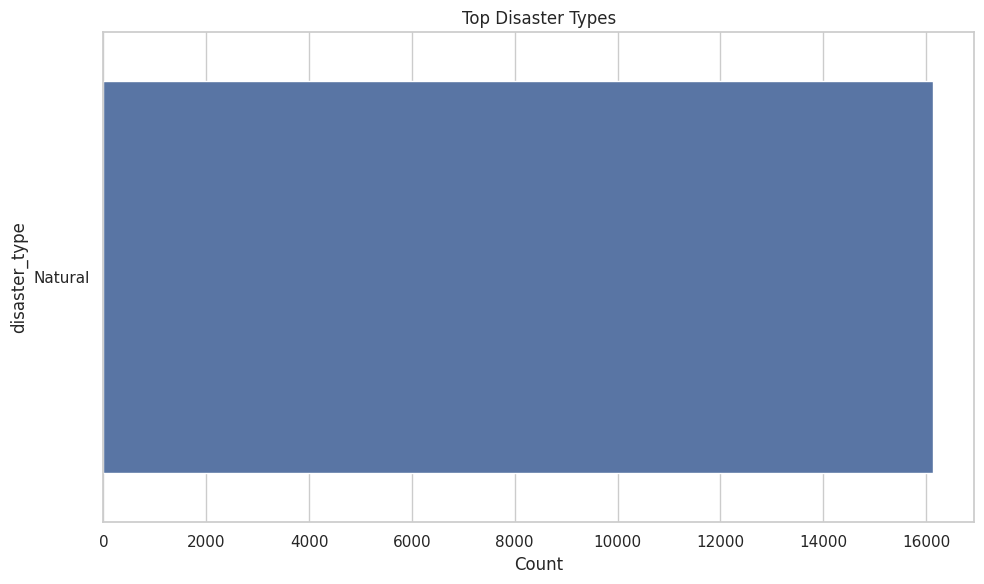

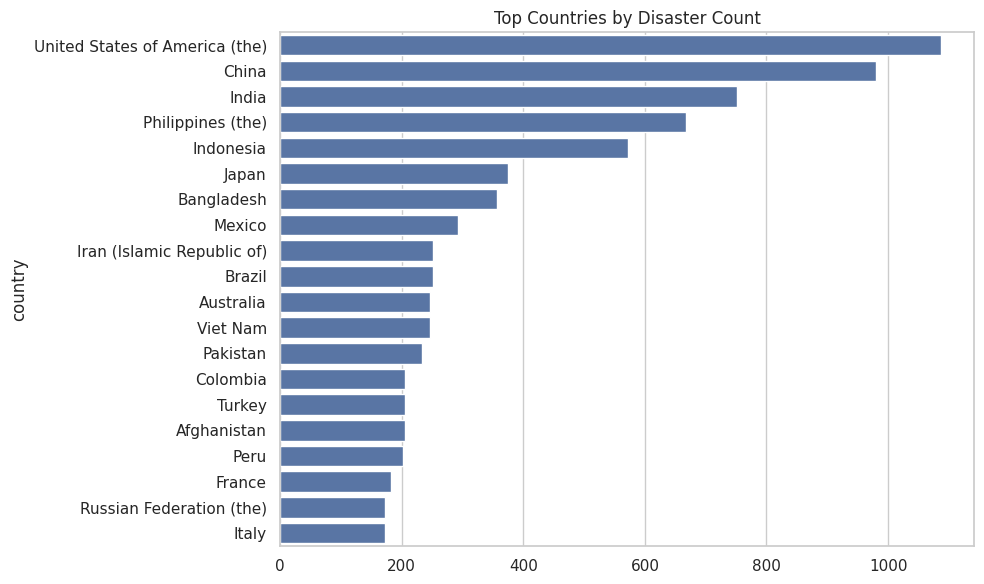

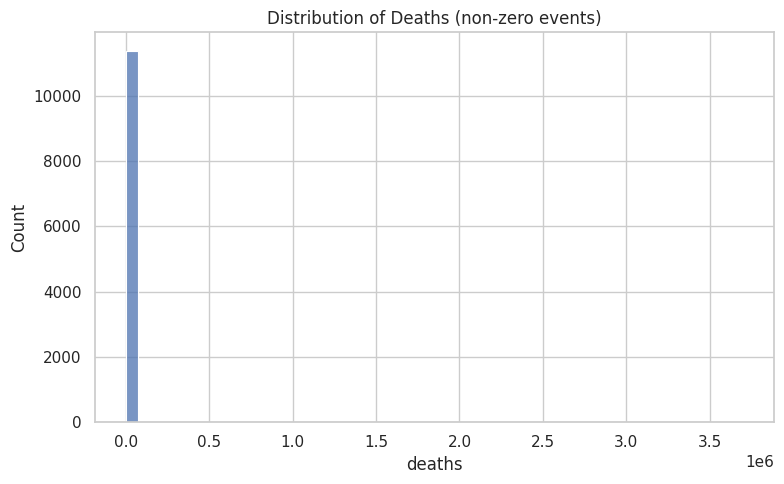

In [11]:
# Top disaster types
if 'disaster_type' in df.columns:
    plt.figure(figsize=(10,6))
    top_types = df['disaster_type'].value_counts().nlargest(15)
    sns.barplot(x=top_types.values, y=top_types.index)
    plt.title("Top Disaster Types")
    plt.xlabel("Count")
    plt.tight_layout()
    plt.savefig("top_disaster_types.png", dpi=150)
    plt.show()

# Top countries
if 'country' in df.columns:
    plt.figure(figsize=(10,6))
    top_countries = df['country'].value_counts().nlargest(20)
    sns.barplot(x=top_countries.values, y=top_countries.index)
    plt.title("Top Countries by Disaster Count")
    plt.tight_layout()
    plt.savefig("top_countries.png", dpi=150)
    plt.show()

# Deaths distribution (non-zero)
if 'deaths' in df.columns:
    plt.figure(figsize=(8,5))
    sns.histplot(df.loc[df['deaths']>0,'deaths'], bins=50)
    plt.title("Distribution of Deaths (non-zero events)")
    plt.tight_layout()
    plt.savefig("deaths_hist.png", dpi=150)
    plt.show()


Bivariate EDA (boxplot / scatter / heatmap)

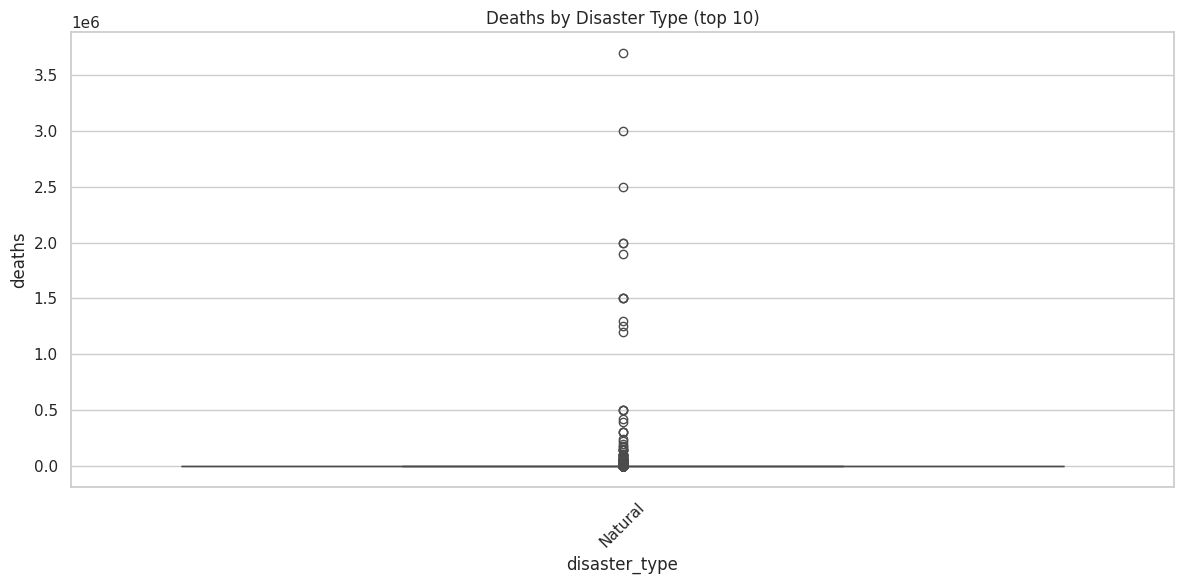

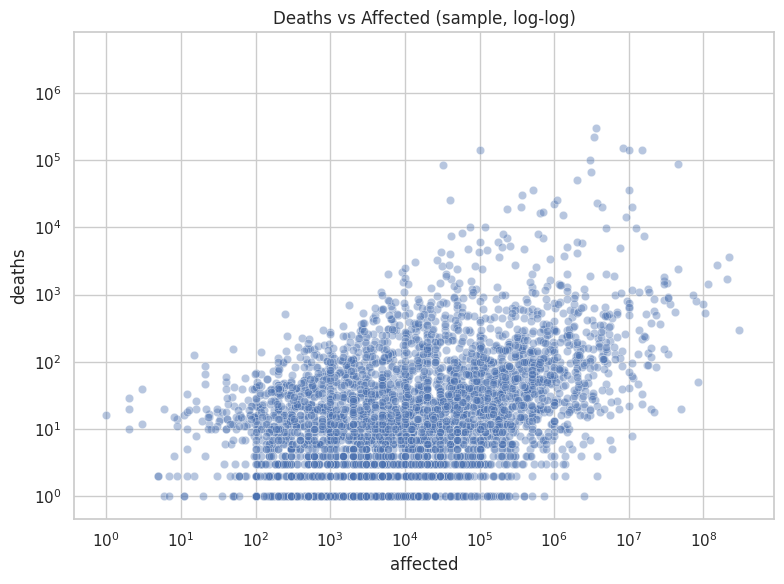

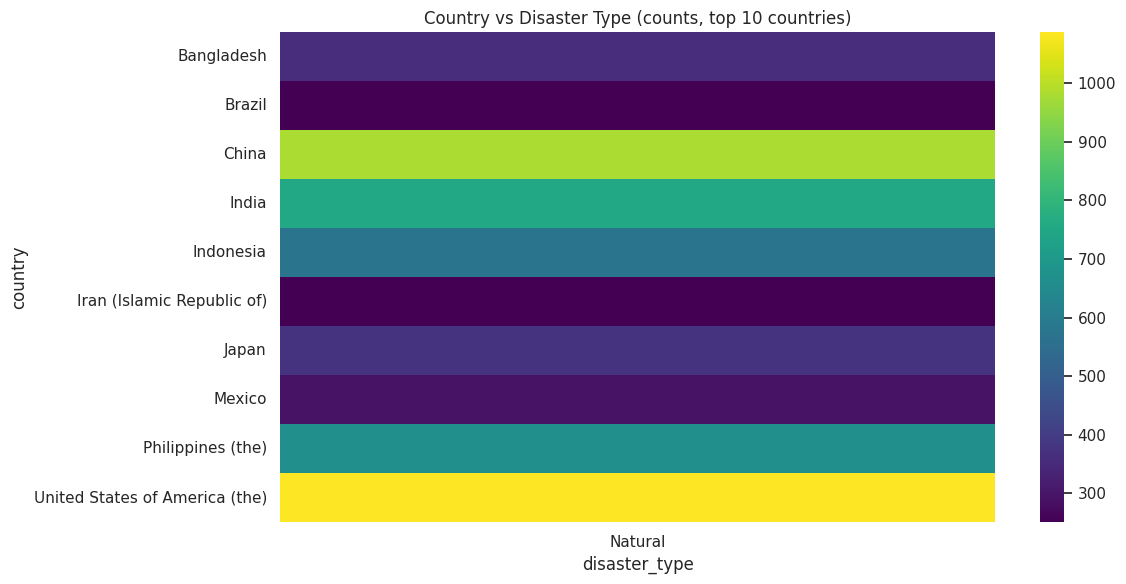

In [12]:
# Boxplot: deaths by top disaster types
if set(['disaster_type','deaths']).issubset(df.columns):
    top10 = df['disaster_type'].value_counts().nlargest(10).index
    subset = df[df['disaster_type'].isin(top10)]
    plt.figure(figsize=(12,6))
    sns.boxplot(x='disaster_type', y='deaths', data=subset)
    plt.xticks(rotation=45)
    plt.title("Deaths by Disaster Type (top 10)")
    plt.tight_layout()
    plt.savefig("deaths_by_type_box.png", dpi=150)
    plt.show()

# Scatter: deaths vs affected (log scale)
if set(['deaths','affected']).issubset(df.columns):
    sample = df.sample(min(10000, len(df)))
    plt.figure(figsize=(8,6))
    sns.scatterplot(x='affected', y='deaths', data=sample, alpha=0.4)
    plt.xscale('log')
    plt.yscale('log')
    plt.title("Deaths vs Affected (sample, log-log)")
    plt.tight_layout()
    plt.savefig("deaths_vs_affected.png", dpi=150)
    plt.show()

# Heatmap country vs disaster type (top 10 countries)
if set(['country','disaster_type']).issubset(df.columns):
    top_countries = df['country'].value_counts().nlargest(10).index
    pivot = pd.crosstab(df[df['country'].isin(top_countries)]['country'],
                        df[df['country'].isin(top_countries)]['disaster_type'])
    plt.figure(figsize=(12,6))
    sns.heatmap(pivot, cmap='viridis')
    plt.title("Country vs Disaster Type (counts, top 10 countries)")
    plt.tight_layout()
    plt.savefig("country_type_heatmap.png", dpi=150)
    plt.show()


Trend analysis: events per year + moving average

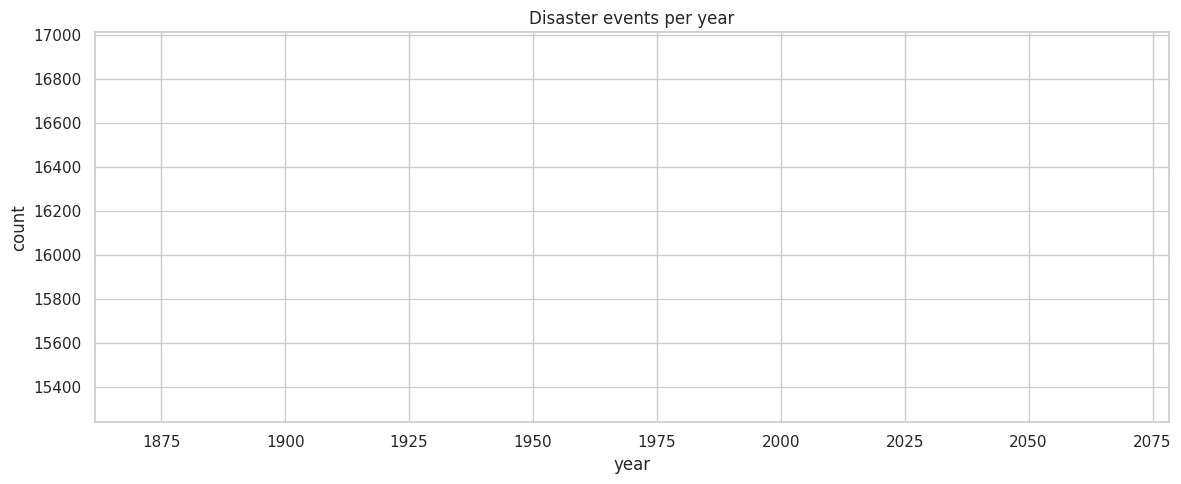

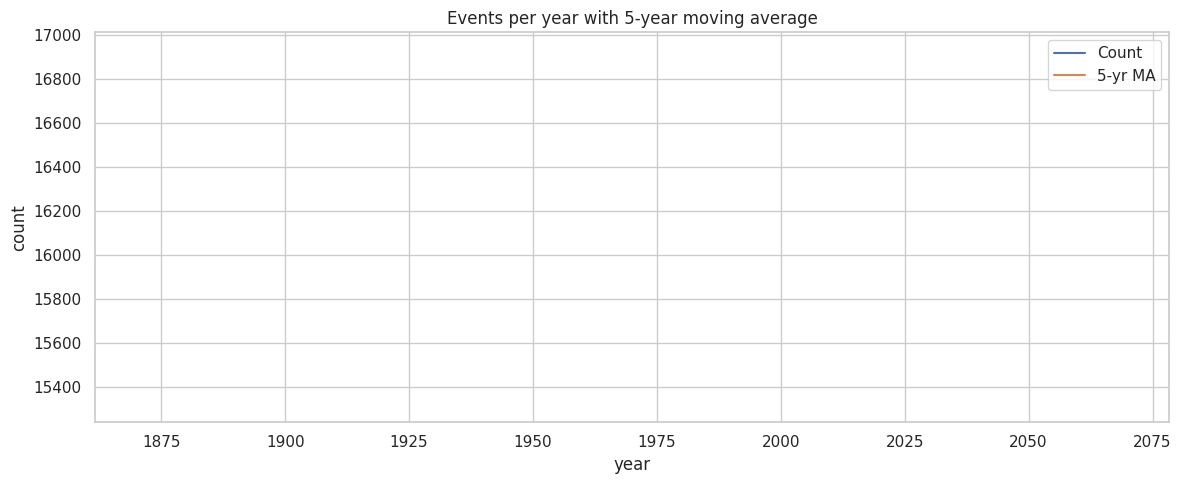

In [13]:
events_per_year = df.groupby('year').size().rename('count').reset_index()
plt.figure(figsize=(12,5))
sns.lineplot(data=events_per_year, x='year', y='count')
plt.title("Disaster events per year")
plt.tight_layout()
plt.savefig("events_per_year.png", dpi=150)
plt.show()

# 5-year moving average
events_per_year['ma5'] = events_per_year['count'].rolling(5, center=True).mean()
plt.figure(figsize=(12,5))
sns.lineplot(x='year', y='count', data=events_per_year, label='Count')
sns.lineplot(x='year', y='ma5', data=events_per_year, label='5-yr MA')
plt.title("Events per year with 5-year moving average")
plt.tight_layout()
plt.savefig("events_per_year_ma.png", dpi=150)
plt.show()


Forecast future event counts (Prophet) with ARIMA fallback

⚠️ Not enough rows for Prophet, skipping directly to ARIMA


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


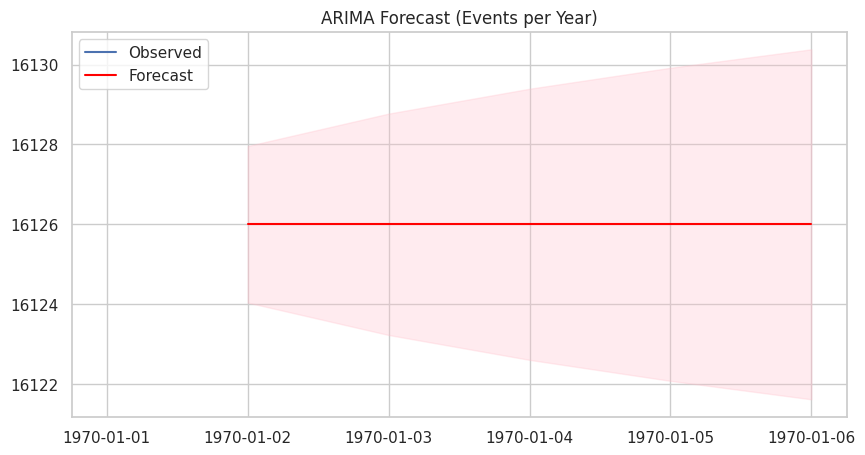

✅ ARIMA forecast saved: /content/forecast_arima.csv and /content/arima_forecast.png


In [19]:
# --- Trend Forecasting (Prophet with ARIMA fallback) ---

# Clean events_per_year first
events_per_year = df.groupby('year').size().rename('count').reset_index()
events_per_year = events_per_year[events_per_year['year'].notna()]
events_per_year = events_per_year[events_per_year['year'] > 0]
events_per_year['year'] = events_per_year['year'].astype(int)

# Prepare Prophet input
ts = events_per_year[['year','count']].copy()
ts['ds'] = pd.to_datetime(ts['year'].astype(str) + '-01-01', errors='coerce')
ts = ts.rename(columns={'count':'y'})[['ds','y']]

# Prophet Forecast (only if we have at least 2 rows)
if ts.dropna().shape[0] >= 2:
    try:
        m = Prophet(yearly_seasonality=False)
        m.add_seasonality(name='yearly', period=365.25, fourier_order=6)
        m.fit(ts)
        future = m.make_future_dataframe(periods=5, freq='Y')
        forecast = m.predict(future)
        m.plot(forecast)
        plt.title("Prophet forecast (events per year)")
        plt.savefig("/content/prophet_forecast.png", dpi=150)
        plt.show()
        forecast[['ds','yhat','yhat_lower','yhat_upper']].to_csv("/content/forecast_prophet.csv", index=False)
        print("✅ Prophet forecast saved: /content/forecast_prophet.csv")
    except Exception as e:
        print("⚠️ Prophet failed:", e)
else:
    print("⚠️ Not enough rows for Prophet, skipping directly to ARIMA")

# ARIMA fallback
# --- ARIMA fallback with proper datetime index ---
# --- ARIMA fallback with proper datetime index ---
try:
    series = events_per_year.set_index('year')['count']
    # Convert year index into datetime index
    series.index = pd.to_datetime(series.index.astype(str) + "-01-01")

    # Fit ARIMA model
    arima_model = sm.tsa.ARIMA(series, order=(1,1,1)).fit()
    arima_fore = arima_model.get_forecast(steps=5)

    # Get forecast and confidence intervals
    arima_df = arima_fore.summary_frame()
    arima_df.to_csv("/content/forecast_arima.csv")

    # Plot ARIMA forecast
    plt.figure(figsize=(10,5))
    plt.plot(series, label="Observed")
    plt.plot(arima_fore.predicted_mean, label="Forecast", color="red")
    conf_int = arima_fore.conf_int()
    plt.fill_between(conf_int.index,
                     conf_int.iloc[:, 0],
                     conf_int.iloc[:, 1],
                     color="pink", alpha=0.3)
    plt.title("ARIMA Forecast (Events per Year)")
    plt.legend()
    plt.savefig("/content/arima_forecast.png", dpi=150)
    plt.show()

    print("✅ ARIMA forecast saved: /content/forecast_arima.csv and /content/arima_forecast.png")
except Exception as e2:
    print("❌ ARIMA failed:", e2)




Create severity labels & train a simple classifier (RandomForest)

In [20]:
if 'deaths' in df.columns:
    q1, q2 = df['deaths'].quantile([0.33,0.66])
    def severity(d):
        if d <= q1: return 'Low'
        elif d <= q2: return 'Medium'
        else: return 'High'
    df['severity'] = df['deaths'].apply(severity)

    # Encode disaster_type and top countries
    le_type = LabelEncoder()
    df['disaster_type_enc'] = le_type.fit_transform(df['disaster_type'].astype(str))

    top_countries = df['country'].value_counts().nlargest(30).index
    df['country_top'] = df['country'].where(df['country'].isin(top_countries), 'Other')
    le_country = LabelEncoder()
    df['country_enc'] = le_country.fit_transform(df['country_top'].astype(str))

    features = ['year','disaster_type_enc','country_enc','affected','damage']
    X = df[features].fillna(0)
    y = df['severity']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    scaler = StandardScaler()
    X_train[['year','affected','damage']] = scaler.fit_transform(X_train[['year','affected','damage']])
    X_test[['year','affected','damage']] = scaler.transform(X_test[['year','affected','damage']])

    clf = RandomForestClassifier(n_estimators=150, random_state=42, class_weight='balanced')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Classification report:")
    print(classification_report(y_test, y_pred))

    # Save model and encoders
    joblib.dump(clf, "rf_severity_model.joblib")
    joblib.dump(le_type, "le_disaster_type.joblib")
    joblib.dump(le_country, "le_country.joblib")
    joblib.dump(scaler, "features_scaler.joblib")
    print("Saved RandomForest model and encoders.")


Classification report:
              precision    recall  f1-score   support

        High       0.53      0.54      0.54      1097
         Low       0.46      0.60      0.52      1097
      Medium       0.39      0.26      0.31      1032

    accuracy                           0.47      3226
   macro avg       0.46      0.47      0.46      3226
weighted avg       0.46      0.47      0.46      3226

Saved RandomForest model and encoders.


Country clustering (KMeans)

In [21]:
if 'country' in df.columns:
    agg = df.groupby('country').agg(
        event_count=('year','count'),
        avg_deaths=('deaths','mean'),
        avg_affected=('affected','mean'),
        avg_damage=('damage','mean')
    ).fillna(0)
    scaler2 = StandardScaler()
    arr = scaler2.fit_transform(agg)
    km = KMeans(n_clusters=4, random_state=42)
    agg['cluster'] = km.fit_predict(arr)
    agg.to_csv("country_clusters.csv")
    print("Saved country_clusters.csv; cluster counts:")
    print(agg['cluster'].value_counts())


Saved country_clusters.csv; cluster counts:
cluster
0    222
3      3
2      2
1      1
Name: count, dtype: int64


In [22]:
insights = []
if 'disaster_type' in df.columns:
    top = df['disaster_type'].value_counts().nlargest(5)
    insights.append("Top disaster types: " + ", ".join([f"{t} ({c})" for t,c in zip(top.index, top.values)]))

if not events_per_year.empty:
    recent = events_per_year[events_per_year['year']>=2000]['count'].mean()
    past = events_per_year[events_per_year['year']<2000]['count'].mean()
    insights.append(f"Avg events/yr since 2000: {recent:.1f}, before 2000: {past:.1f}")

if 'country' in df.columns:
    topc = df['country'].value_counts().nlargest(5).index.tolist()
    insights.append("Top affected countries: " + ", ".join(topc))

with open("project_insights.txt","w") as f:
    for line in insights:
        f.write(line+"\n")

print("Saved project_insights.txt")

readme = """# Climate-Induced Disaster Pattern Analysis - README

## Project Summary
Analyzes disaster data (1900–2021) to identify patterns, trends, and risks.

## Files produced
- disasters_final.csv : cleaned dataset
- Plots: top_disaster_types.png, top_countries.png, deaths_hist.png, ...
- forecast_prophet.csv or forecast_arima.csv : trend forecast
- rf_severity_model.joblib : RandomForest severity classifier
- country_clusters.csv : country clusters
- project_insights.txt : quick insights

Run the notebook cells in order to reproduce results.
"""
with open("README_PROJECT.md","w") as f:
    f.write(readme)

print("Saved README_PROJECT.md")


Saved project_insights.txt
Saved README_PROJECT.md
